In [2]:
!pip install -q shap

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import joblib
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (1).csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
print("Shape of dataset:", df.shape)
df.info()
df.describe()

Shape of dataset: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBill

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


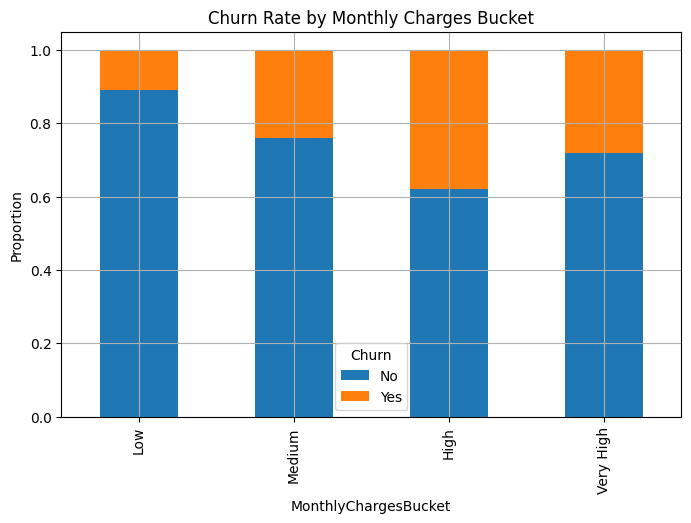

In [7]:
# Real-Time Aggregation Example

df['MonthlyChargesBucket'] = pd.cut(df['MonthlyCharges'], bins=[0, 35, 70, 100, 150], labels=["Low", "Medium", "High", "Very High"])
monthly_churn = df.groupby('MonthlyChargesBucket')['Churn'].value_counts(normalize=True).unstack().fillna(0)
monthly_churn.plot(kind='bar', stacked=True, figsize=(8,5))
plt.title("Churn Rate by Monthly Charges Bucket")
plt.ylabel("Proportion")
plt.grid(True)
plt.show()

In [8]:
# Handling Missing Values

print(df.isnull().sum())
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


customerID              0
gender                  0
SeniorCitizen           0
Partner                 0
Dependents              0
tenure                  0
PhoneService            0
MultipleLines           0
InternetService         0
OnlineSecurity          0
OnlineBackup            0
DeviceProtection        0
TechSupport             0
StreamingTV             0
StreamingMovies         0
Contract                0
PaperlessBilling        0
PaymentMethod           0
MonthlyCharges          0
TotalCharges            0
Churn                   0
MonthlyChargesBucket    0
dtype: int64


In [9]:
df.drop("customerID", axis=1, inplace=True)

In [10]:
# Encode Categorical Variables

cat_cols = df.select_dtypes(include='object').columns.tolist()
cat_cols.remove('Churn')
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])
for col in cat_cols:
    if df[col].nunique() == 2:
        df[col] = le.fit_transform(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

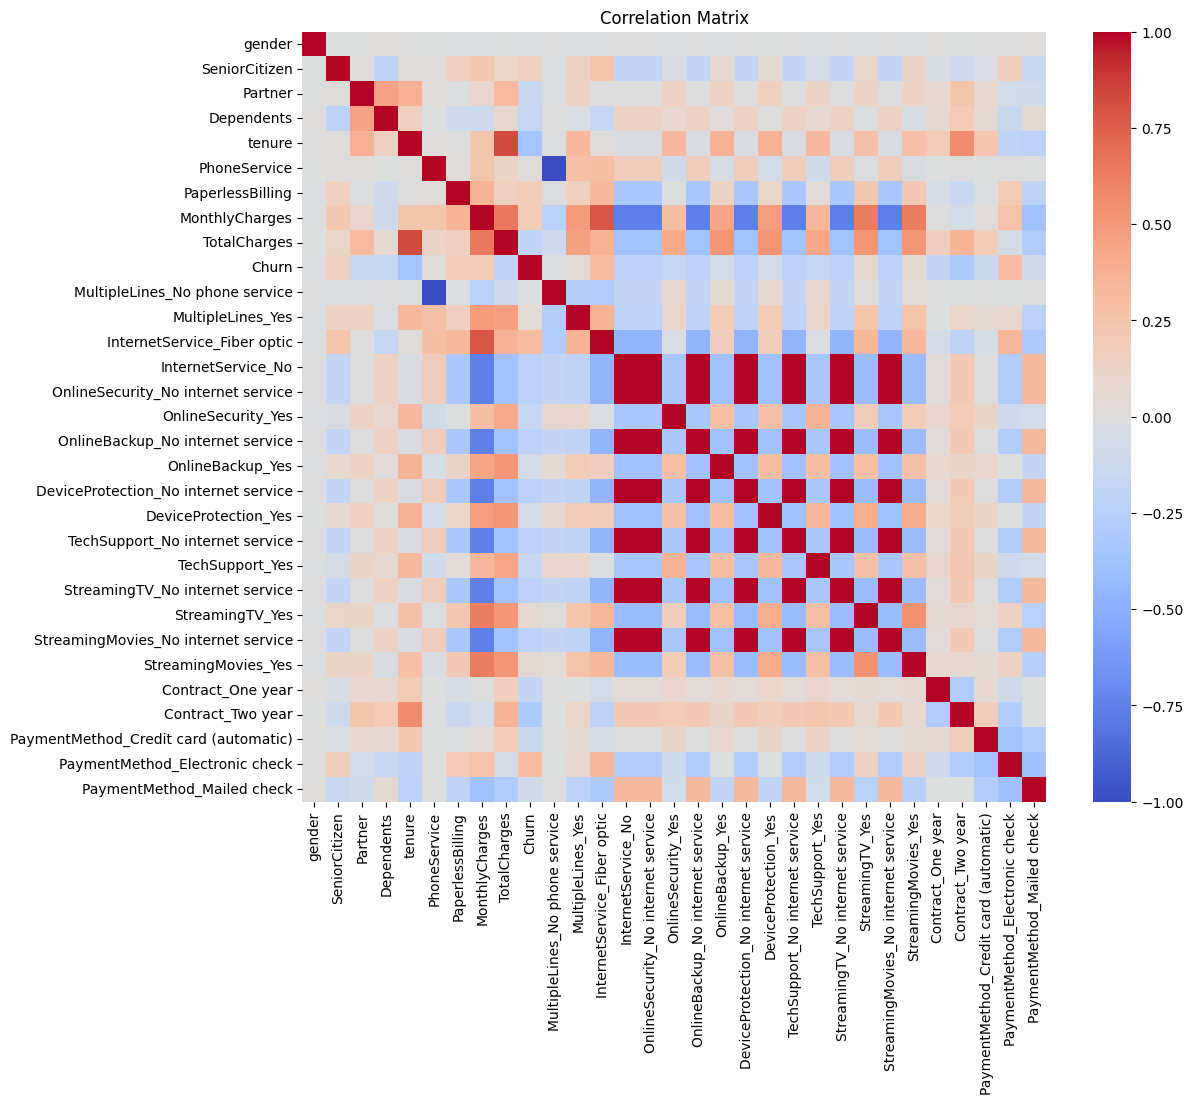

In [12]:
# Correlation Matrix
# Exclude the non-numeric 'MonthlyChargesBucket' column before calculating correlation
df_numeric = df.drop('MonthlyChargesBucket', axis=1)
plt.figure(figsize=(12,10))
sns.heatmap(df_numeric.corr(), cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [16]:
# Feature Scaling & Train-Test Split
X = df.drop(['Churn', 'MonthlyChargesBucket'], axis=1) # Drop Churn and MonthlyChargesBucket
y = df['Churn']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

In [17]:
# Train XGBoost Model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [18]:
# Evaluation
y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7847813742191937

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1294
           1       0.61      0.51      0.55       467

    accuracy                           0.78      1761
   macro avg       0.72      0.70      0.71      1761
weighted avg       0.77      0.78      0.78      1761


Confusion Matrix:
 [[1146  148]
 [ 231  236]]


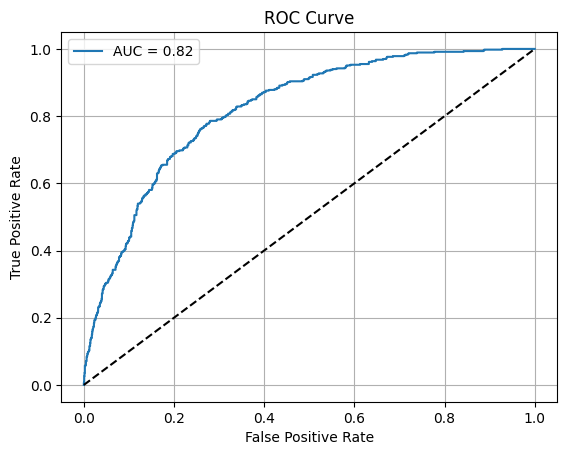

In [19]:
# ROC Curve
probs = xgb.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(roc_auc_score(y_test, probs)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

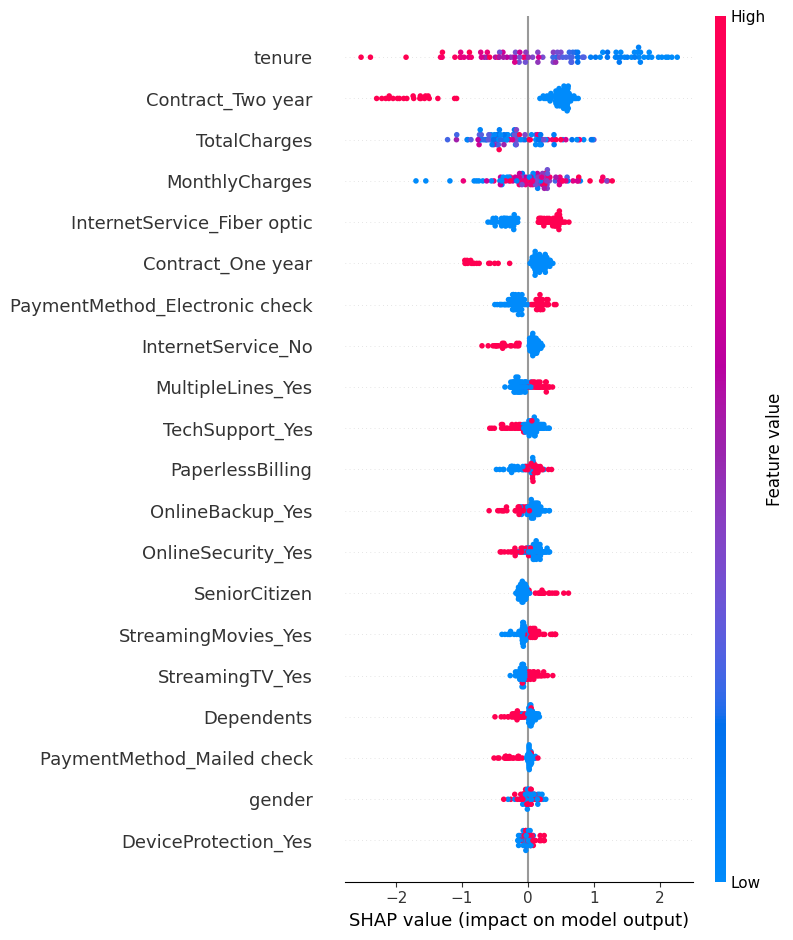

In [20]:
# SHAP Interpretability
explainer = shap.Explainer(xgb, X_train)
shap_values = explainer(X_test[:100])
shap.summary_plot(shap_values, X_test[:100], feature_names=X.columns.tolist())

Top 10 important features:
 InternetService_Fiber optic       0.391124
Contract_Two year                 0.178990
InternetService_No                0.099107
Contract_One year                 0.091082
StreamingMovies_Yes               0.023822
tenure                            0.023144
PhoneService                      0.016217
PaymentMethod_Electronic check    0.015972
PaperlessBilling                  0.014695
MultipleLines_Yes                 0.013100
dtype: float32


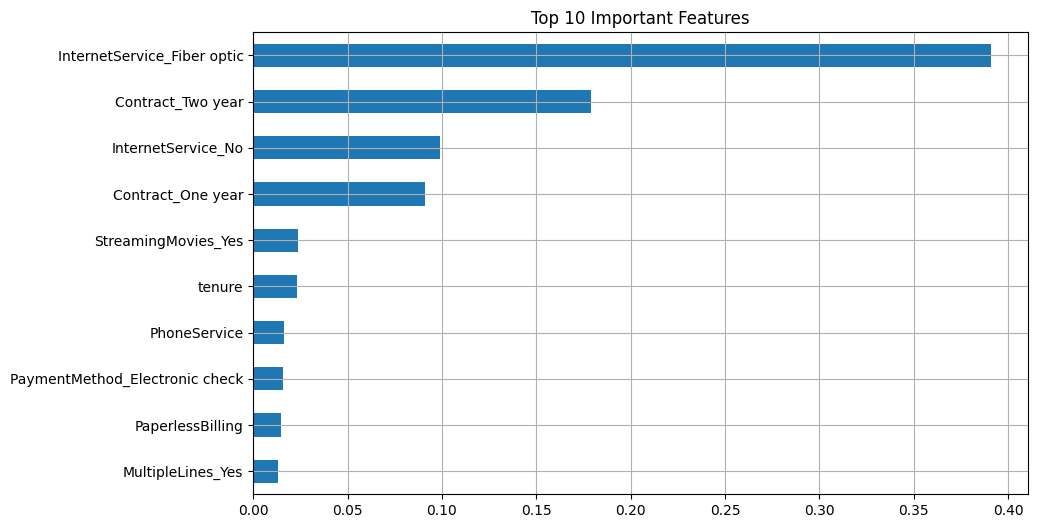

In [21]:
# Business Insights
importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 important features:\n", importances.head(10))
plt.figure(figsize=(10,6))
importances.head(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

In [22]:
# Export Model
joblib.dump(xgb, "xgb_churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Model and scaler saved.")

Model and scaler saved.


In [23]:
from google.colab import files
files.download("xgb_churn_model.pkl")
files.download("scaler.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>